In [ ]:
import math
import importlib
from typing import Literal

import torch
from torch import Tensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.ax_helper import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client
from src.ax_helper import get_full_strategy

import pickle

silence_ax_client()


<function src.ax_helper.silence_ax_client()>

-0.0 -0.9874311636230129


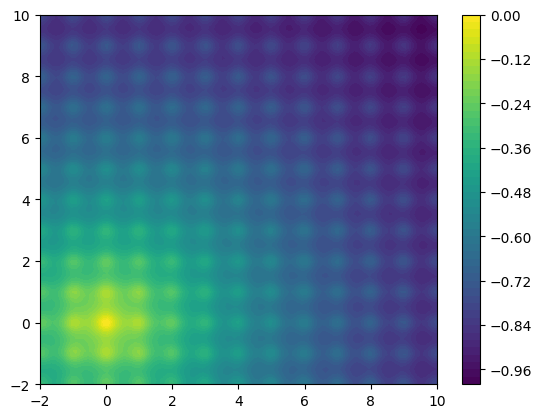

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

In [3]:
import logging
import builtins

class SuppressInfoPrefix(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('[INFO')

# Create and register the filter globally (all loggers)
_filter = SuppressInfoPrefix()
root_logger = logging.getLogger()
root_logger.addFilter(_filter)
for handler in root_logger.handlers:
    handler.addFilter(_filter)

# Also add to any already-created loggers
for logger_name, lg in logging.root.manager.loggerDict.items():
    if isinstance(lg, logging.Logger):
        lg.addFilter(_filter)
        for h in lg.handlers:
            h.addFilter(_filter)

# Optional: suppress bare print() lines starting with '[INFO'
_original_print = builtins.print
def filtered_print(*args, **kwargs):
    if args and isinstance(args[0], str) and args[0].startswith('[INFO'):
        return
    _original_print(*args, **kwargs)

builtins.print = filtered_print


   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0   4.066734  28.936209
2         2_0  12.767709   5.908069
3         3_0  90.484536  32.839576
4         4_0   2.845096   1.646400
5         5_0   1.280184  85.440118
6         6_0  40.558930   2.326244
7         7_0  28.486994  12.930488
8         8_0   9.037007   4.861250
9         9_0   6.433579  55.923248
10       10_0  20.199994   1.116415
11       11_0  42.891810  20.068501
12       12_0   1.348550   9.837567
13       13_0   2.025398  14.299125
14       14_0  64.164307   3.806606
15       15_0  13.502582  68.428163
16       16_0   4.283754   2.515343
17       17_0   5.286794  62.532777
18       18_0  16.847728   2.957840
19       19_0  68.670722  16.828506
20       20_0   2.185368   3.475778
21       21_0   1.679334  21.178499
22       22_0  53.039165   7.512029
23       23_0  21.813810  42.740134
24       24_0   6.879624   1.177150
25       25_0   8.363726  10.232633
26       26_0  26.655023   4

<Axes: xlabel='x0', ylabel='x1'>

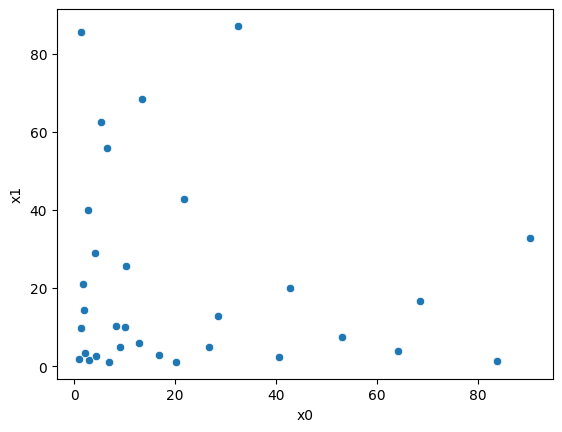

In [4]:

client = Client()
client.verbose_logging = False
#client.verbose_logging = False

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

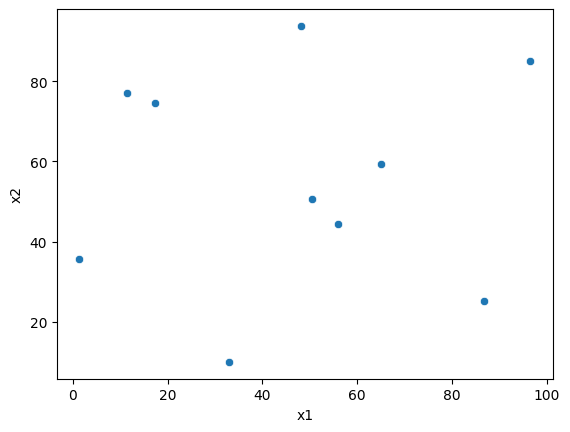

In [5]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.



(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

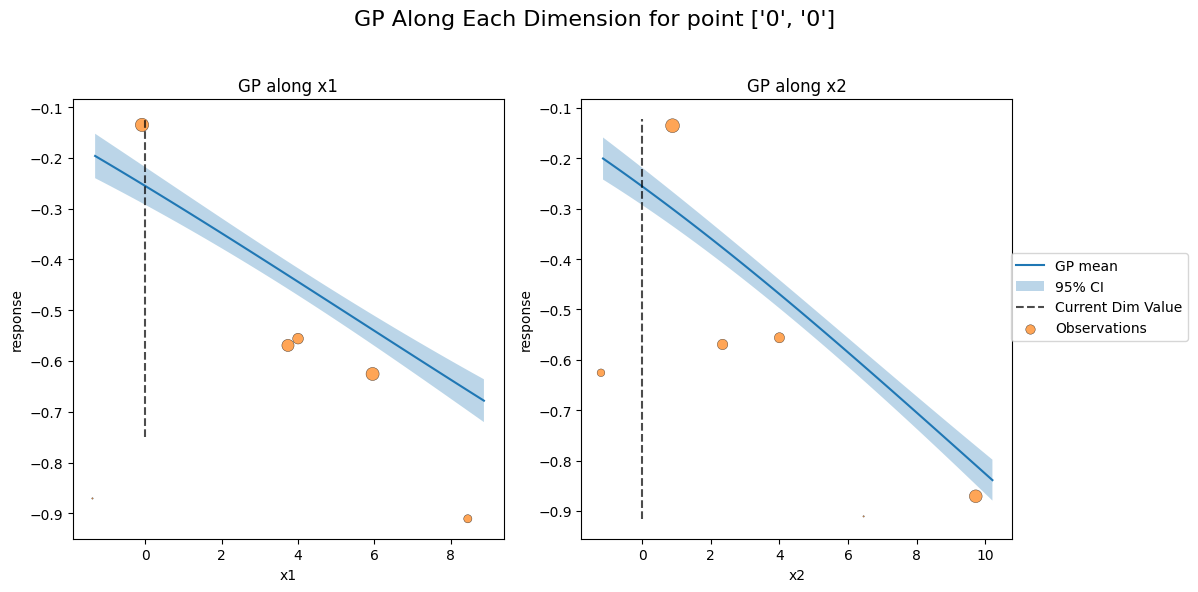

In [6]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, df, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [7]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,3.735466,2.342759,-0.569431
2,2_0,8.447771,6.451225,-0.910770
3,3_0,5.952760,-1.199758,-0.625633
4,4_0,-1.387487,9.718355,-0.870791
5,5_0,-0.089266,0.884848,-0.135126


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [8]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=1, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

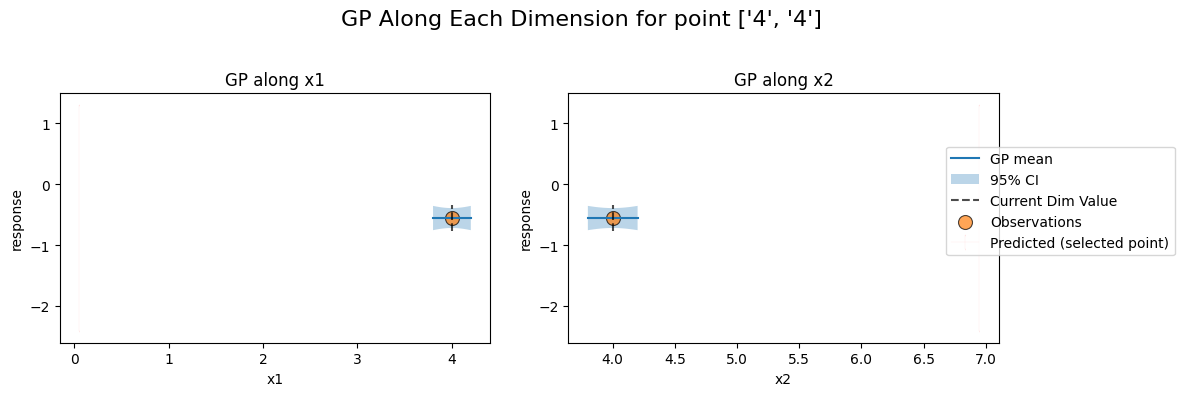

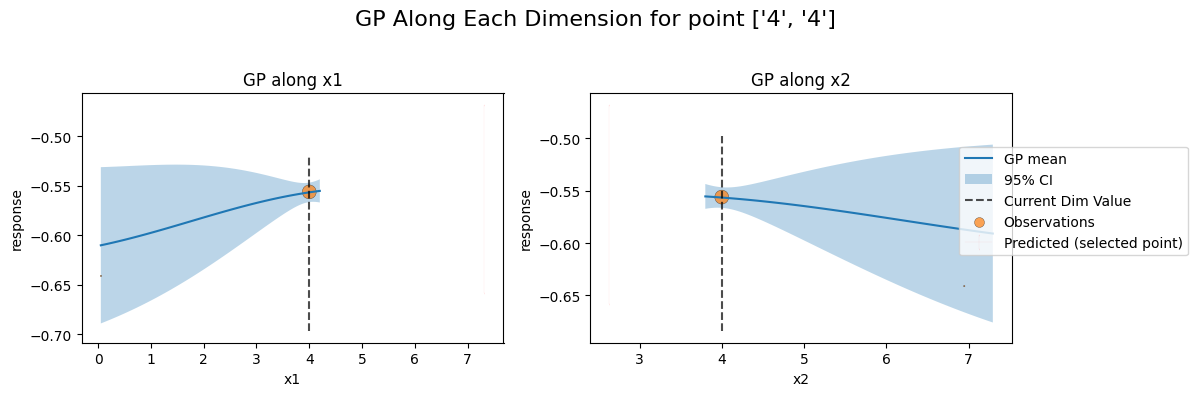

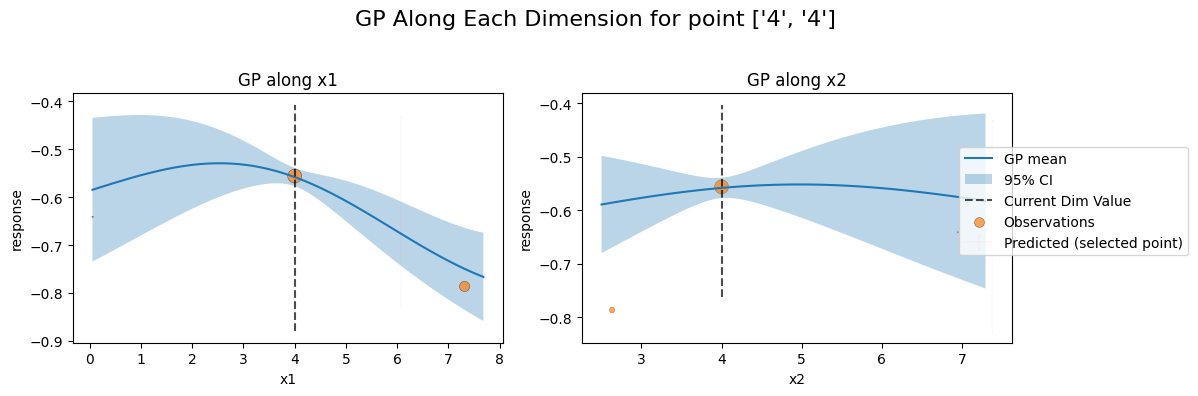

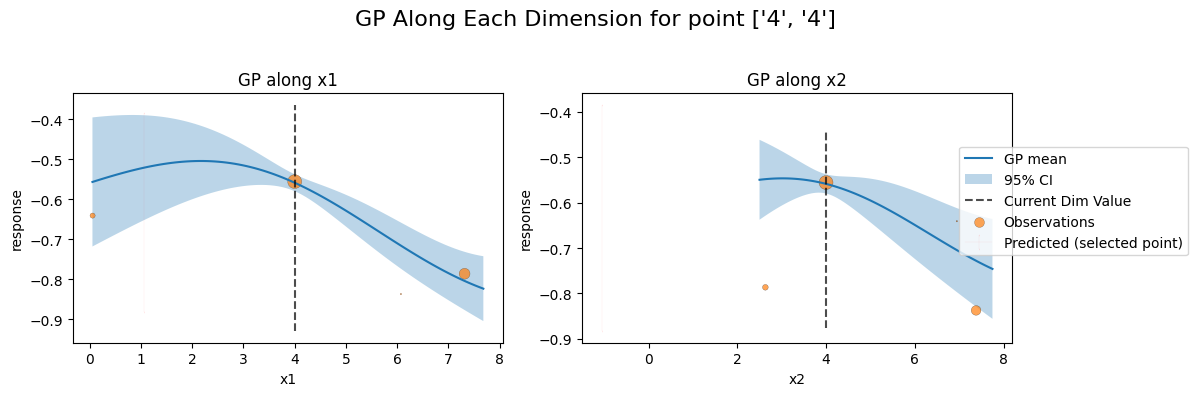

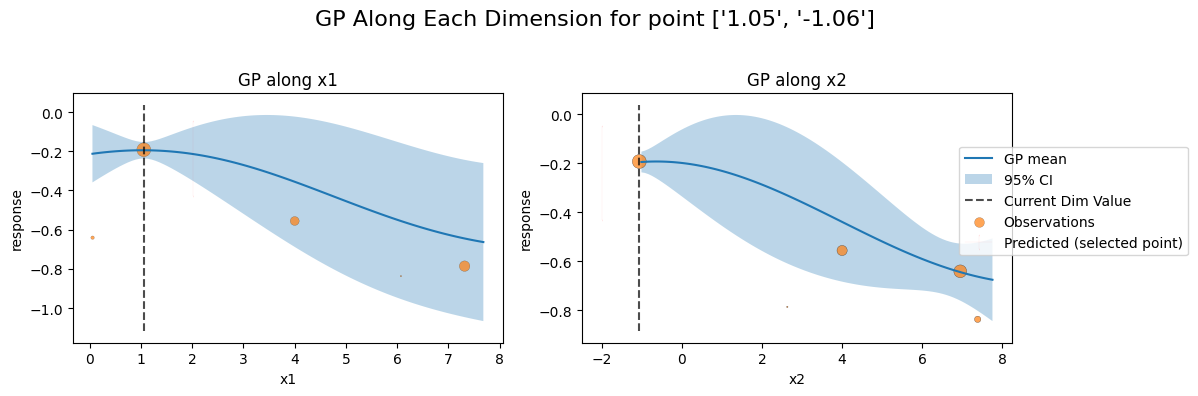

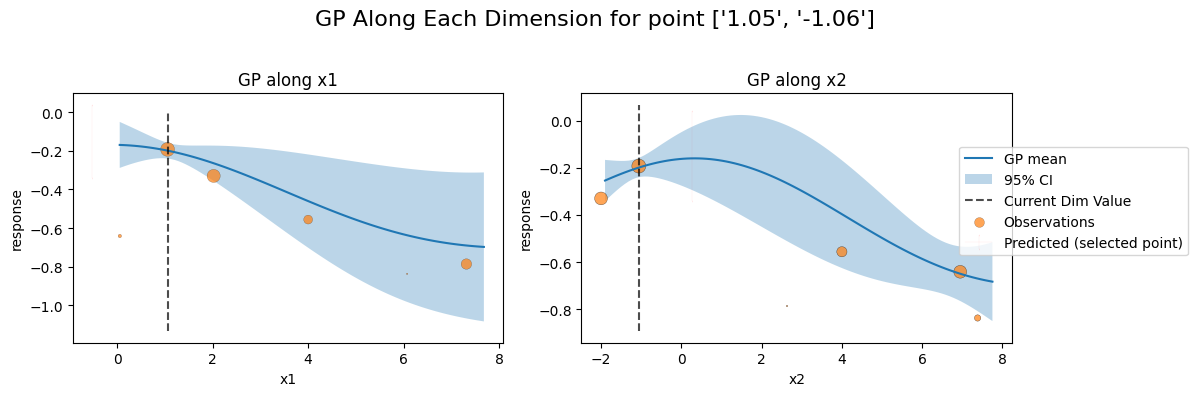

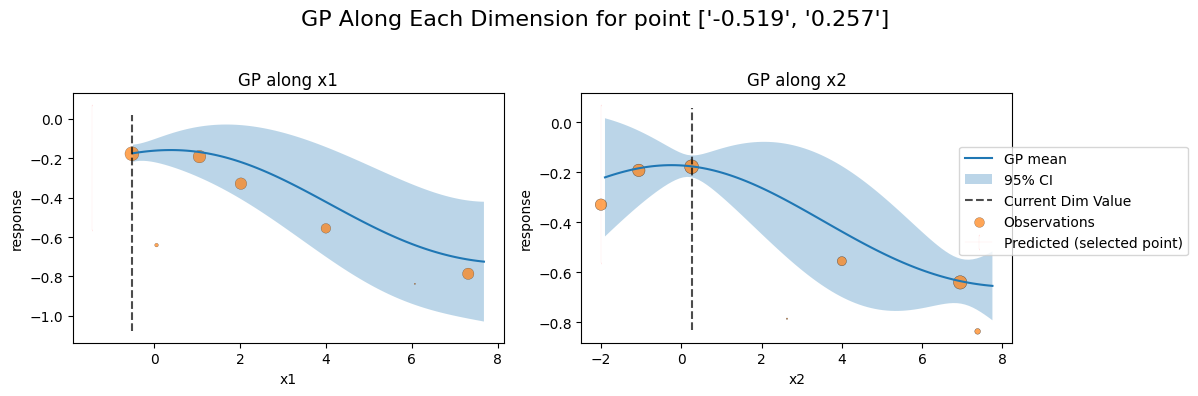

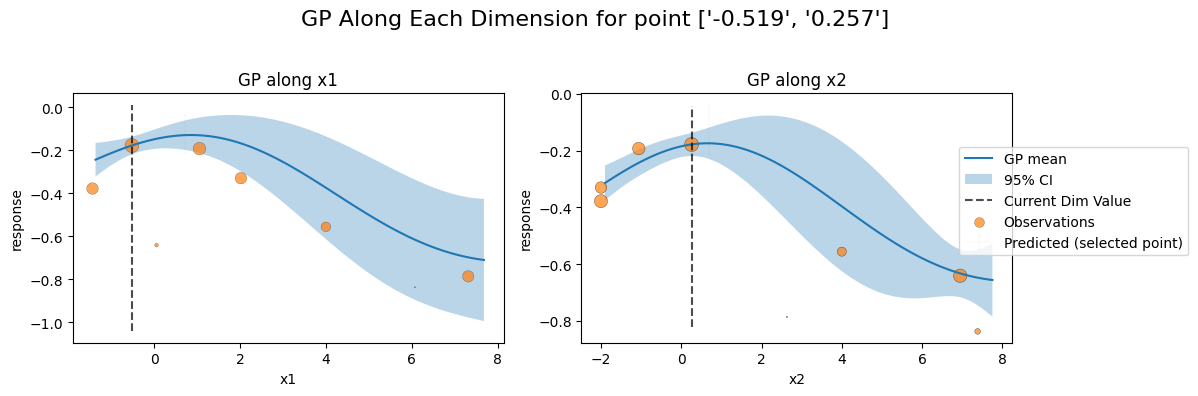

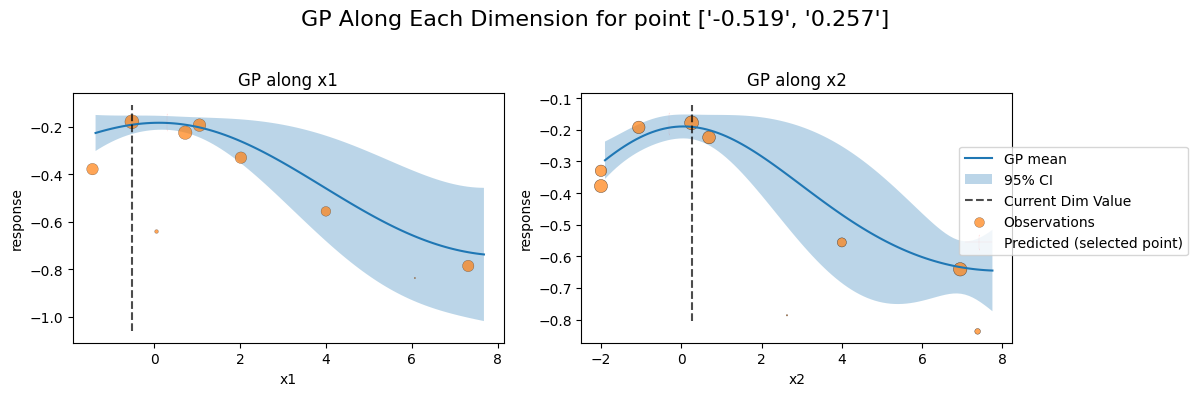

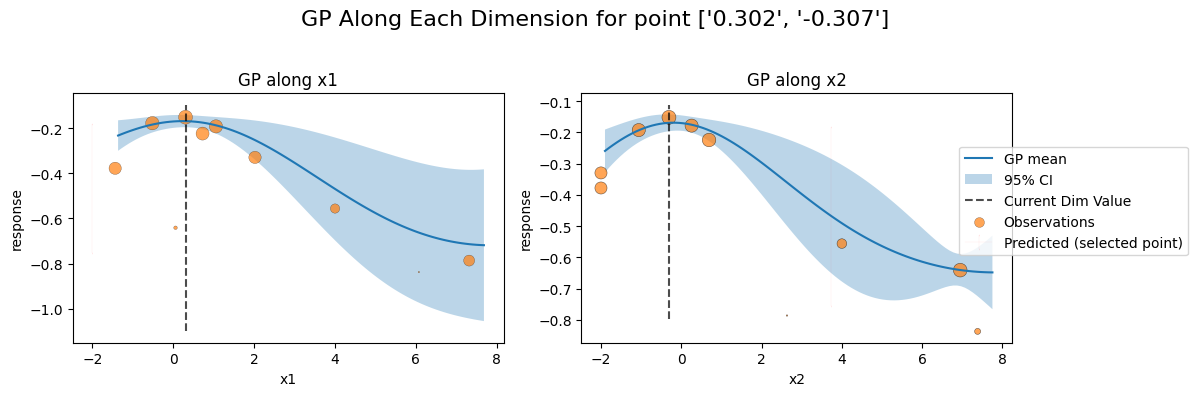

In [9]:
import matplotlib.pyplot as plt
for _ in range(10):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()


In [10]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,3.735466,2.342759,-0.569431
2,2_0,8.447771,6.451225,-0.910770
3,3_0,5.952760,-1.199758,-0.625633
4,4_0,-1.387487,9.718355,-0.870791
5,5_0,-0.089266,0.884848,-0.135126


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [11]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x: x + np.random.normal(0, 1)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

In [ ]:

SequentialRuns

__main__.SequentialRuns

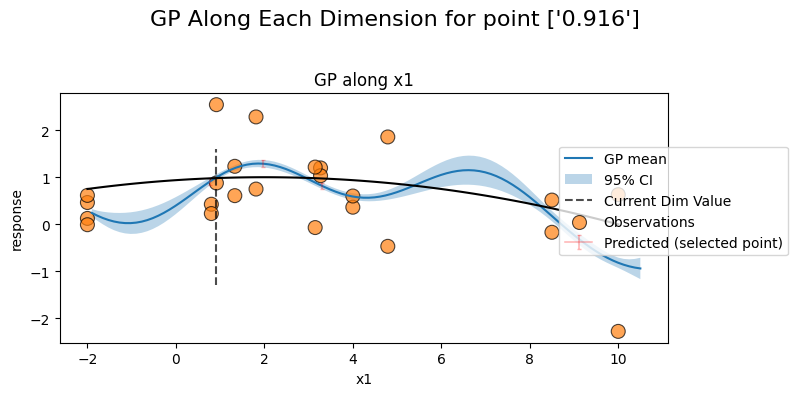

In [13]:
tester = SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)
runs.plot_GP(SingleTaskGP, figsize=(8, 4))
plot_test()

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

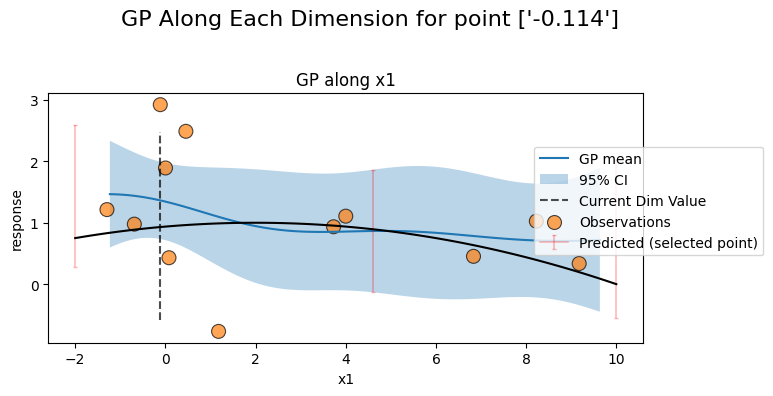

In [14]:
class GammaNoiseSGP(SingleTaskGP):
    """Just add a lot of assumed noise"""

    def __init__(
        self,
        train_X,
        train_Y,
        noise_concentration: float = 10,
        noise_rate: float = 10,
    ):

        likelihood = GaussianLikelihood(
            noise_prior=GammaPrior(noise_concentration, noise_rate)
        )

        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            likelihood=likelihood,
        )


runs = tester.run(
    GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(GammaNoiseSGP, figsize=(8, 4))


plot_test()

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

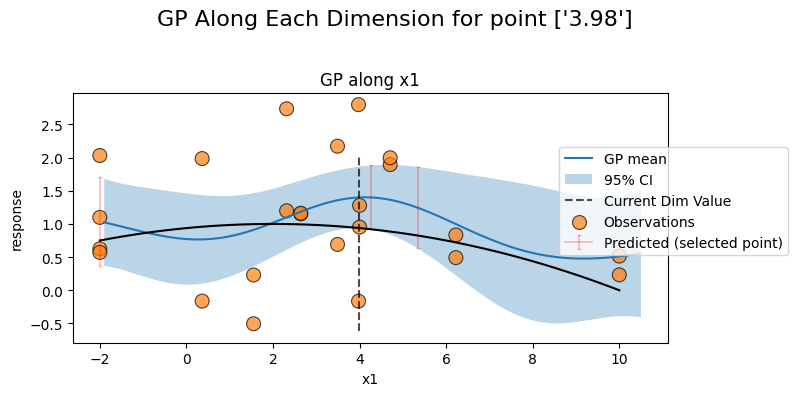

In [15]:
runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [16]:
# Hartmann 6D benchmark (domain: [0,1]^6). Standard form is for minimization.
# We return the negative so it can be used as a maximization objective (larger is better).
_h6_alpha = torch.tensor([1.0, 1.2, 3.0, 3.2])
_h6_A = torch.tensor([
    [10,  3, 17,  3,  1, 11],
    [ 0.05, 10, 17,  0.1, 8, 14],
    [ 3,  3.5, 1.7, 10, 17, 8],
    [17,  8,  0.05, 10, 0.1, 14],
])
_h6_P = 1e-4 * torch.tensor([
    [1312, 1696, 5569, 124, 8283, 5886],
    [2329, 4135, 8307, 3736, 1004, 9991],
    [2348, 1451, 3522, 2883, 3047, 6650],
    [4047, 8828, 8732, 5743, 1091, 381],
])

def hartmann6(x1, x2, x3, x4, x5, x6):
    """
    Hartmann-6 function (negated for maximization).
    Usage:
        hartmann6(x) where x is length-6 iterable in [0,1]
        or hartmann6(x1, x2, x3, x4, x5, x6)
    """
    args = (x1, x2, x3, x4, x5, x6)
    if len(args) == 1 and hasattr(args[0], "__len__"):
        x = torch.as_tensor(args[0], dtype=torch.float32)
    else:
        x = torch.as_tensor(args, dtype=torch.float32)
    if x.shape != (6,):
        raise ValueError("hartmann6 expects 6-dimensional input.")
    inner = torch.sum(_h6_A * (x - _h6_P) ** 2, dim=1)
    value = -torch.sum(_h6_alpha * torch.exp(-inner))  # standard (to be minimized)
    return -value  # negate so higher is better

# Quick check at known optimum (~minimum of original, hence maximum after negation)
_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = float(hartmann6(*_h6_x_opt))
h_6_max

3.416637659072876

In [17]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = SequentialRuns(hartmann6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester

## Sequential runs no noise

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\optim\optimize.py:753: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\optim\optimize.py:753: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\optim\optimize.py:753: RuntimeWarning:

Optimization failed on the second try, after generating a new set of ini

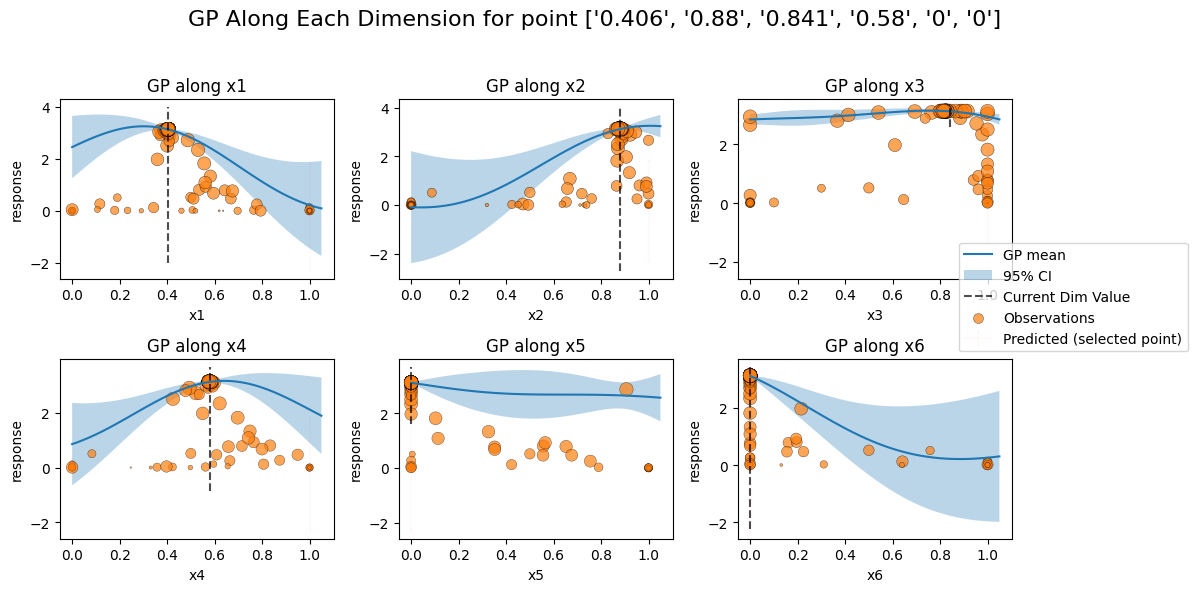

In [18]:
def noise_fn(x):
    return x

save_dir = "data/bayes_sim/"
runs = tester.run(SingleTaskGP, n_runs=100, technical_repeats=1, batch_size=1, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(SingleTaskGP)

In [19]:
def get_y_data(runs, dim_names, test_func):

    df = runs.get_batch_observations().sort_values(by='trial_index', ascending=True)
    df = df.groupby(["trial_index", *dim_names])['response'].mean().reset_index()

    df['y_true'] = df[dim_names_h6].apply(lambda r: float(test_func(*r.values)), axis=1)
    df['error'] = df['response'] - df['y_true']
    return df

def get_above_percentile(df, max_val, percentile = 0.95):
    cut_off = percentile*max_val
    df = df[(df['response']>cut_off) & (df['y_true']>cut_off)]
    return df
   
df = get_y_data(runs, dim_names_h6, hartmann6)
df = get_above_percentile(df, h_6_max, 0.9)
df.head(5)

,trial_index,x1,x2,x3,x4,x5,x6,response,y_true,error
22,22,0.376036,0.891908,0.764680,0.579738,0.0,0.0,3.084682,3.084682,0.0
26,26,0.387833,0.872421,0.540706,0.598574,0.0,0.0,3.080150,3.080150,0.0
27,27,0.393571,0.886371,0.693534,0.589728,0.0,0.0,3.113659,3.113659,0.0
49,49,0.398215,0.867687,0.831295,0.579081,0.0,0.0,3.123865,3.123865,0.0
50,50,0.399338,0.863487,0.888193,0.576588,0.0,0.0,3.121644,3.121644,0.0


In [20]:
df = get_y_data(runs, dim_names_h6, hartmann6)
df

,trial_index,x1,x2,x3,x4,x5,x6,response,y_true,error
0,0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406,0.516406,0.0
1,1,0.764803,0.424186,0.100417,0.422480,0.789705,0.310314,0.022165,0.022165,0.0
2,2,0.343286,0.653406,0.646573,0.806614,0.423046,0.641461,0.122186,0.122186,0.0
3,3,0.190338,0.087305,0.300252,0.083294,0.004977,0.758048,0.504531,0.504531,0.0
4,4,0.642846,0.865409,0.941108,0.715013,0.652840,0.161278,0.784278,0.784278,0.0
...,...,...,...,...,...,...,...,...,...,...
96,96,0.405191,0.885775,0.903773,0.582868,0.000000,0.000000,3.129876,3.129876,0.0
97,97,0.793859,0.493669,1.000000,0.000000,0.000000,0.000000,0.003610,0.003610,0.0
98,98,0.406367,0.882983,0.811889,0.584017,0.000000,0.000000,3.129056,3.129056,0.0
99,99,0.403679,0.871502,0.818415,0.576429,0.000000,0.000000,3.128962,3.128962,0.0


In [21]:
def _single_run(params):
    tr, noise = params
    def noise_fn(x):
        return x + np.random.normal(0, noise)
    local_tester = SequentialRuns(hartmann6, hartmann6_range_parameters, dim_names_h6, metric_name)
    runs = local_tester.run(
        GammaNoiseSGP,
        n_runs=100,
        technical_repeats=tr,
        batch_size=1,
        noise_fn=noise_fn,
        plot_each=False,
    )
    df_local = get_y_data(runs, dim_names_h6, hartmann6)

    return df_local

In [ ]:
param_grid = [(tr, float(n)) for tr in range(1, 9) for n in np.linspace(0, 2.2, 11)]

r_n_dict = {el: _single_run(el) for el in param_grid}

with open(save_dir+'r1-9_noise1-2_dict.pkl', 'wb') as f:
    pickle.dump(r_n_dict, f)

r_n_dict

In [ ]:
result = pd.DataFrame(
    [{'technical_repeats': tr, 'noise': noise, 'best_response': best}
     for (tr, noise), best in r_n_dict.items()]
).sort_values(['technical_repeats', 'noise']).reset_index(drop=True)
result

,technical_repeats,noise,best_response
0,1,0.00,trial_index x1 x2 x3 ...
1,1,0.22,trial_index x1 x2 x3 ...
2,1,0.44,trial_index x1 x2 x3 ...
3,1,0.66,trial_index x1 x2 x3 ...
4,1,0.88,trial_index x1 x2 x3 ...
...,...,...,...
83,8,1.32,trial_index x1 x2 x3 ...
84,8,1.54,trial_index x1 x2 x3 ...
85,8,1.76,trial_index x1 x2 x3 ...
86,8,1.98,trial_index x1 x2 x3 ...


In [ ]:
r_n_dict

processed_dict = {}
for (tr, noise), df in r_n_dict.items():
    print(df['y_true'].max())
    #df = get_above_percentile(df, h_6_max, 0.6)
    processed_dict[(tr, noise)] = df

processed_dict

1.5641748905181885
0.6761985421180725
2.2090413570404053
0.5339521765708923
0.7103486657142639
0.5164057016372681
1.213407039642334
0.5164057016372681
0.9773629307746887
0.9674651622772217
0.5164057016372681
1.8230715990066528
0.6538750529289246
1.8907718658447266
0.8545454144477844
0.8895413875579834
0.7664543986320496
1.229248046875
1.2910079956054688
1.1318379640579224
0.5164057016372681
1.1633845567703247
1.7869874238967896
1.9412988424301147
2.7558517456054688
0.5164057016372681
0.5164057016372681
0.5164057016372681
0.5164057016372681
0.8054777383804321
0.6244006156921387
0.5164057016372681
0.5164057016372681
0.8145254254341125
1.3914941549301147
0.5164057016372681
2.0038020610809326
2.007021427154541
0.5164057016372681
1.7032681703567505
0.5164057016372681
0.5164057016372681
2.131023645401001
0.5164057016372681
0.843153178691864
2.203528881072998
2.7913057804107666
0.7025457620620728
0.5164057016372681
2.2760486602783203
0.5164057016372681
0.5164057016372681
0.5164057016372681
0.

{(1,
  0.0):     trial_index        x1        x2        x3        x4        x5        x6  \
 0             0  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
 1             1  0.153827  0.516501  0.663504  0.357013  0.693217  0.751702   
 2             2  0.516317  0.428315  0.365999  0.634753  0.020056  0.258272   
 3             3  0.912935  0.790028  0.930936  0.170392  0.338702  0.050180   
 4             4  0.292883  0.139164  0.102428  0.822339  0.886260  0.557266   
 5             5  0.727251  0.520658  0.351082  0.595074  0.725752  0.685185   
 6             6  0.355252  0.485195  0.566051  0.456685  0.403454  0.452844   
 7             7  0.345620  0.503488  0.650362  0.404656  0.225883  0.277063   
 8             8  0.280820  0.493325  0.537265  0.471612  0.379615  0.601533   
 9             9  0.182827  0.496515  0.527896  0.475917  0.309512  0.703733   
 10           10  0.182011  0.229809  0.739651  0.742685  0.324963  0.713060   
 
     response    y_true  e